In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from math import *

F_geo = lambda x,p: np.floor(np.log(1-x)/np.log(1-p))
f = lambda x,p: p* (1-p)**(x-1)
Trans = lambda x: 10**(-0.2*x/10)
def h(p_list):
    y_list = np.zeros(len(p_list))
    for i,p in enumerate(p_list):
        if p<1e-6 or (1-p)<1e-6:
            y_list[i]= 0
        else:
            y_list[i]= -p*np.log2(p)-(1-p)*np.log2(1-p)
    return y_list

# One repeater

In [3]:
# constants
c = 2e5 # speed of light in fiber [km/s]
p_link = 1.0 # photon insertion loss incorporates various efficiencies of the experimental hardware

def T_parallel_cutoff(L1,L2,τ_cut,τ_coh, mu_link, F_link, Nmax=100000):
    """ calculates the performance of parallel scheme with one repeater
    inputs:
        L1,L2: elementary link lengths
        τ_cut: cut-off time
        τ_coh: coherence time of quantum memories
        mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
        entanglement swapping error
        F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
        *** only valid for L1=L2 ****
        Nmax: ensemble size for averaging
    outputs:
        Raw_rate: 1/ expected value of total time for e2e entanglement delivery
        *** application specific quantities:
        skr: secret key rate for qkd (does not include idle times of end memories)
        F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
    """
    Nmax = int(Nmax) # to make sure Nmax is an integer
    τ1 = L1/c
    τ2 = L2/c
    p1 = p_link*Trans(L1)
    p2 = p_link*Trans(L2)
    N1 = F_geo(np.random.uniform(low=p1, high=1, size=(Nmax,)),p1)
    N2 = F_geo(np.random.uniform(low=p2, high=1, size=(Nmax,)),p2)
    Ts = np.max(np.array([(2*N1-1)*τ1,2*N2*τ2]),axis=0) # swap moment
    t1L = Ts-(2*N1-1)*τ1 # elapsed time of leftside repeater's memory 
    t1R = Ts-2*(N2-1)*τ2 # elapsed time of rightside repeater's memory 
    indsL = np.argwhere( t1L <= τ_cut )[:,0]
    indsR = np.argwhere( t1R <= τ_cut )[:,0]
    succ_inds = np.intersect1d(indsL,indsR)
    T_succ = np.sum(Ts[succ_inds]+ τ1) 
    T_fail = (2*τ1/p1 + τ_cut)*(Nmax-len(succ_inds))

    raw_rate = len(succ_inds)/(T_succ+T_fail)
    t_idle_qkd = t1L + t1R
    f_memory_qkd = np.mean(np.exp(- t_idle_qkd[succ_inds]/τ_coh) )
    N_links = 2
    mu_e2e = mu_link**(2*N_links-1)
    # secret key rate calculations
    f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
    ex = (1 - mu_e2e)/2
    ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
    skr = raw_rate * (1-h([ex])-h([ez]))
    #  fidelity of e2e Bell pairs
    tA = Ts+ τ1 -2*(N1-1)*τ1 # elapsed time of A's memory 
    tB = Ts+ τ1 -(2*N2-1)*τ2 # elapsed time of B's memory 
    t_idle_bell = tA + tB + t1L + t1R
    f_memory_bell = np.mean(np.exp(- t_idle_bell[succ_inds]/τ_coh) )
    f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
    F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4
    
    return raw_rate, skr, F_e2e

def T_sequential_cutoff(L1,L2,τ_cut,τ_coh, mu_link, F_link):
    """ calculates the performance of parallel scheme with one repeater
    inputs:
        L1,L2: elementary link lengths
        τ_cut: cut-off time
        τ_coh: coherence time of quantum memories
        mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
        entanglement swapping error
        F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
        *** only valid for L1=L2 ****
        Nmax: ensemble size for averaging
    outputs:
        Raw_rate: 1/ expected value of total time for e2e entanglement delivery
        *** application specific quantities:
        skr: secret key rate for qkd (does not include idle times of end memories)
        F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
    """
    None
    raw_rate, skr, F_e2e = 0, 0, 0
    return raw_rate, skr, F_e2e


In [32]:
τ_coh = 0.01
τ_cut = 0.5*τ_coh # cutoff
F_link = 1 # fidelity of local BP
mu_link = 1 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)

Le2e_list = np.linspace(10,200,21) # e2e distance [km]
raw_rate_par = np.zeros(len(Le2e_list))
skr_par = np.zeros(len(Le2e_list))
Fe2e_par = np.zeros(len(Le2e_list))

for i, Le2e in enumerate(Le2e_list):
    L1 = Le2e/2
    L2 = Le2e/2
    p1 = p_link*Trans(L1)
    q1= 1-p1 
    raw_rate_par[i], skr_par[i], Fe2e_par[i] = T_parallel_cutoff(L1, L2, τ_cut, τ_coh, mu_link, F_link, Nmax=1e6)
    

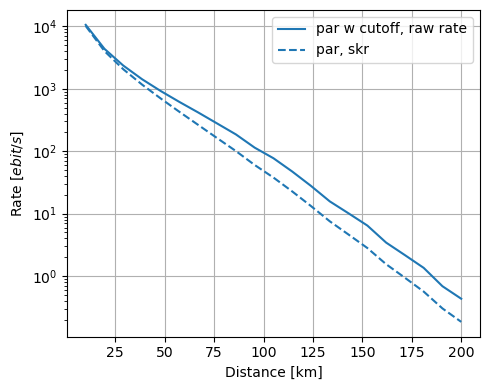

In [33]:
plt.figure(figsize=(5,4))
# plt.plot(Le2e_list,raw_rate_par,"-",color="C0", label="par, raw rate")
plt.plot(Le2e_list,raw_rate_par,"-",color="C0", label="par w cutoff, raw rate")
plt.plot(Le2e_list,skr_par,"--",color="C0", label="par, skr")
plt.yscale("log")
plt.xlabel("Distance [km]")
plt.ylabel(r"Rate $[ebit/s]$")
# plt.ylim([1e-4,1e5])
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig("figures_realtime/one_repeater_no_cutoff.pdf")
plt.show()

## Rate vs. cutoff time

In [22]:
τ_coh = 0.1 # coherence time [sec]
τ_cut_list = np.linspace(0.01,0.5)*τ_coh # cutoff [sec]
Le2e = 150 # e2e distance [km]


raw_rate_par = np.zeros(len(τ_cut_list))
skr_par = np.zeros(len(τ_cut_list))
Fe2e_par = np.zeros(len(τ_cut_list))
for i_t, τ_cut in enumerate(τ_cut_list):
    L1 = Le2e/2
    L2 = Le2e/2
    raw_rate_par[i_t], skr_par[i_t], Fe2e_par[i_t] = T_parallel_cutoff(L1, L2, τ_cut, τ_coh, mu_link, F_link)


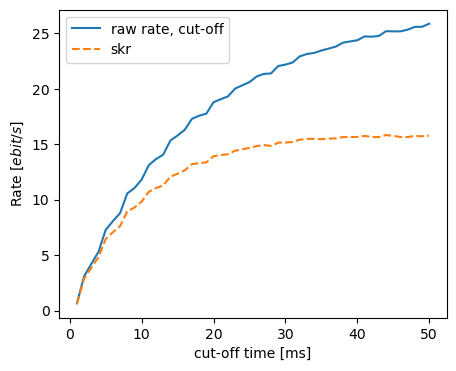

In [23]:
plt.figure(figsize=(5,4))
plt.plot(τ_cut_list*1e3,raw_rate_par,"-",label="raw rate, cut-off")
plt.plot(τ_cut_list*1e3,skr_par,"--",label="skr")
# plt.plot(τ_cut_list*1e3,1/inv_rate_par+0*τ_cut_list,"k--",label="no cut-off")

plt.ylabel(r"Rate $[ebit/s]$")
plt.xlabel("cut-off time [ms]")
plt.legend()
plt.show()
